In [1]:
#install libraries
!pip install texthero

     |████████████████████████████████| 235 kB 9.6 MB/s 
     |████████████████████████████████| 1.5 MB 38.8 MB/s 
     |████████████████████████████████| 749 kB 54.0 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import texthero as hero
from tensorflow import keras
from sklearn import preprocessing
from tensorflow.keras import layers, Model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#read and shuffle the dataframe
df = pd.read_csv('vgsales.csv')
df = df.sample(frac = 1)
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
8085,8087,Battle Commander: Hachibushu Shura no Heihou,SNES,1991.0,Strategy,Banpresto,0.00,0.00,0.18,0.00,0.18
13472,13474,Nihon Pro Mahjong Kishikai Kanshuu: Pro Ni Nar...,DS,2005.0,Misc,Success,0.00,0.00,0.04,0.00,0.04
8869,8871,T'ai Fu: Wrath of the Tiger,PS,1998.0,Action,Activision,0.08,0.06,0.00,0.01,0.15
15628,15631,Rising Zan: The Samurai Gunman,PS,1998.0,Action,Agetec,0.01,0.01,0.00,0.00,0.02
1329,1331,Dragon Quest Monsters: Joker 2,DS,2010.0,Role-Playing,Square Enix,0.11,0.08,1.24,0.02,1.45


In [6]:
# clean the text column
df['Name'] = hero.clean(df['Name'])
df['Genre'] = hero.clean(df['Genre'])

In [7]:
# pad tokens 
vocab = dict()
vocab['<pad>'] = 1
cnt = 2

for i in df['Name']:
  txt = i.split(' ')
  for j in txt:

    if vocab.get(j) == None:
      vocab[j] = cnt
      cnt += 1

In [8]:
#length of vocabulary
len(vocab)

8611

In [9]:
# get the text
Name_X = []

for i in range(len(df)):
  txt = df['Name'][i].split(' ')
  temp = []
  for j in txt:
    temp.append(vocab[j])
  Name_X.append(temp)

In [10]:
Name_X = tf.keras.preprocessing.sequence.pad_sequences(
    Name_X , maxlen=20, dtype='int32', padding='post',
    truncating='post'
)

In [11]:
X = df.drop(['Genre',	'Publisher', 'Platform', 'Name', 'Rank', 'Year'], axis=1)
y = df['Genre']

In [12]:
# label-encoding
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [13]:
# convert label-encoding to categorical
y = tf.keras.utils.to_categorical( y, num_classes=df['Genre'].nunique(), dtype='int32')

In [14]:
# max. length of the text
def Name_len(x):
  return len(x.split(' '))

name_max_len = max(df['Name'].apply(lambda x : Name_len(x)).to_list())

In [25]:
# create the model
model_name = keras.Sequential()
model_name.add(tf.keras.layers.Embedding(input_dim=len(vocab)+1000, output_dim=64, input_length=20))
model_name.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(20, 64)))
model_name.add(tf.keras.layers.Dense(10, activation='relu'))

model_regress = keras.Sequential()
model_regress.add(tf.keras.layers.Input(shape=(5,)))
model_regress.add(tf.keras.layers.Dense(64, activation='relu'))
model_regress.add(tf.keras.layers.Dense(10, activation='relu'))

concat = tf.keras.layers.concatenate([model_name.output, model_regress.output])
final_op = tf.keras.layers.Dense(12, activation='softmax')(concat)

full_model = tf.keras.Model(inputs=[model_name.input, model_regress.input], outputs=[final_op])
full_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_2_input (InputLayer)  [(None, 20)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 20, 64)       615104      ['embedding_2_input[0][0]']      
                                                                                                  
 input_3 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 64)           33024       ['embedding_2[0][0]']            
                                                                                            

In [26]:
#train test_Split
X_train1, X_train2, y_train = Name_X[:15000], X[:15000], y[:15000]
X_test1, X_test2, y_test = Name_X[15000:], X[15000:], y[15000:]

In [27]:
#compile and fit the model
full_model.compile( loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])
history = full_model.fit([X_train1, X_train2], y_train, verbose=2, batch_size=64, epochs=50)

Epoch 1/50
235/235 - 6s - loss: 2.3880 - accuracy: 0.1803 - 6s/epoch - 26ms/step
Epoch 2/50
235/235 - 5s - loss: 2.3314 - accuracy: 0.2041 - 5s/epoch - 20ms/step
Epoch 3/50
235/235 - 5s - loss: 2.2687 - accuracy: 0.2188 - 5s/epoch - 19ms/step
Epoch 4/50
235/235 - 5s - loss: 2.2207 - accuracy: 0.2297 - 5s/epoch - 20ms/step
Epoch 5/50
235/235 - 5s - loss: 2.1734 - accuracy: 0.2437 - 5s/epoch - 20ms/step
Epoch 6/50
235/235 - 5s - loss: 2.1321 - accuracy: 0.2517 - 5s/epoch - 20ms/step
Epoch 7/50
235/235 - 5s - loss: 2.0926 - accuracy: 0.2594 - 5s/epoch - 20ms/step
Epoch 8/50
235/235 - 5s - loss: 2.0580 - accuracy: 0.2670 - 5s/epoch - 20ms/step
Epoch 9/50
235/235 - 5s - loss: 2.0261 - accuracy: 0.2761 - 5s/epoch - 20ms/step
Epoch 10/50
235/235 - 5s - loss: 1.9995 - accuracy: 0.2847 - 5s/epoch - 20ms/step
Epoch 11/50
235/235 - 5s - loss: 1.9667 - accuracy: 0.2987 - 5s/epoch - 20ms/step
Epoch 12/50
235/235 - 5s - loss: 1.9314 - accuracy: 0.3107 - 5s/epoch - 20ms/step
Epoch 13/50
235/235 - 5s 

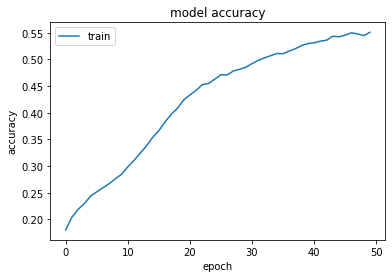

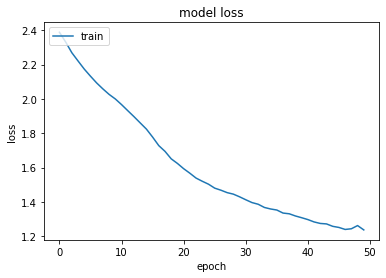

In [29]:
from matplotlib import pyplot as plt

# plot model accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#plot model loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [30]:
# predict the output
output = full_model.predict([Name_X[:128], X[:128]])
output = np.argmax(output, axis=1)

In [34]:
# accuracy over the test set
sum = 0

for i,j in zip(output, np.argmax(y_test, axis=1)):
  if i == j:
    sum += 1
print(sum/len(output)*100)

14.0625


In [35]:
# model output
print(le.inverse_transform(output))

['role playing' 'misc' 'action' 'action' 'role playing' 'action' 'action'
 'action' 'fighting' 'action' 'adventure' 'puzzle' 'misc' 'shooter'
 'action' 'action' 'action' 'action' 'sports' 'platform' 'action' 'action'
 'misc' 'action' 'action' 'shooter' 'action' 'platform' 'sports' 'action'
 'role playing' 'action' 'sports' 'action' 'adventure' 'strategy' 'action'
 'platform' 'role playing' 'simulation' 'adventure' 'shooter' 'action'
 'adventure' 'role playing' 'misc' 'sports' 'action' 'sports' 'action'
 'action' 'action' 'action' 'action' 'adventure' 'sports' 'action'
 'sports' 'misc' 'action' 'sports' 'sports' 'fighting' 'action' 'action'
 'action' 'sports' 'role playing' 'action' 'action' 'sports' 'action'
 'action' 'misc' 'shooter' 'shooter' 'sports' 'action' 'action'
 'role playing' 'role playing' 'action' 'role playing' 'action' 'action'
 'action' 'action' 'sports' 'racing' 'action' 'role playing' 'adventure'
 'adventure' 'action' 'simulation' 'misc' 'misc' 'puzzle' 'shooter'
 'ac